## Try again calculating the energy flux. 

This time, do it in place for each timestep, and be very careful taking into account the varying z coordinate.

the `e` variable effectively gives us a z* coordinate for that snapshot. However, these are *not* the z* levels of the resting pressure! Maybe that's where I've gone wrong in the past. Let's say we have a $P_0(\overline{z})$ profile, where $\overline{z}$ is the original z coordinate. Then, $P'(\overline{z})$ is calculated by subtracting the anomaly in this $\overline{z}$ coordinate. However, all of our outputs actually come in the $z(x,y,t)$ coordinate! 

An issue with this in the past has been that pressure anomalies have been dominated by the surface displacement. However, this might be due to me not remapping these pressures back onto the original $\overline{z}$ coordinate before calculating pressure anomalies?

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import xrft
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")

import autolib as al
from dask.distributed import Client
# client = Client(n_workers=28)
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36531,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:44799,Total threads: 4
Dashboard: /proxy/46153/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:35391,


# Meridional Energy Flux

In [2]:
basepath = "/home/149/ab8992/bottom_near_inertial_waves/revision/double_yextent"
# e = xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False).isel(xh = 5,yh = 600).e.load()
# u = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).isel(xq = 5,yh = 600).u.load()
# v = xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False).isel(xh = 5,yq = 600).v.load()

ez = xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False,parallel=True,decode_cf = False).sel(time = slice(0,8000)).isel(yh = slice(499,501)).e.mean("yh").persist()
print("u")
uz = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False,parallel=True,decode_cf = False).sel(time = slice(0,8000)).isel(yh = slice(499,501)).u.mean("yh").persist()
# vz = xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False,decode_cf = False).sel(time = slice(0,8000)).isel(yq = 500).v.chunk({"xh":1})


u


In [3]:
def ModalEnergy(data,nmodes = 5,N = np.sqrt((2 * 9.8) / (3275 * 1027))):
    """
    Data should be dataset with e,u,v and times still in hrs
    """
    data = data.assign_coords(time = data.time * 60) ## Convert to seconds
    zl = -1 * (data.e.isel(zi = range(0,20)).values + data.e.isel(zi = range(1,21))).values / 2
    zi = data.e
    if "xq" in data.dims:
        data["u"] = data.u.interp(xq = data.xh)
    if "yh" in data.dims:
        data["v"] = data.v.interp(yq = data.yh)

    w = data.e.differentiate("time").fillna(0)
    u_modes = xr.DataArray(
        np.zeros(data.u.isel(zl = 0).shape + (nmodes,)),
        dims = data.u.isel(zl = 0).dims + ('mode',),
        coords = data.u.isel(zl = 0).coords
    ).assign_coords(mode = np.arange(1,nmodes + 1)).rename("u")
    v_modes = u_modes.rename("v") * 0
    w_modes = xr.DataArray(
        np.zeros(w.isel(zi = 0).shape + (nmodes,)),
        dims = w.isel(zi = 0).dims + ('mode',),
        coords = w.isel(zi = 0).coords
    ).assign_coords(mode = np.arange(1,nmodes + 1)).rename("w")

    for n in range(1,nmodes + 1):
        phi_zl = np.sqrt(2/4000) * np.cos(zl * n * np.pi / 4000) ## Simple vertical modes with constant N
        phi_zi = np.sqrt(2/4000) * np.cos(zi * n * np.pi / 4000) ## Same but with zi vertical coord


        # print(phi_zi * w)

        v_modes.loc[{"mode":n}] = scipy.integrate.trapezoid(phi_zl * data.v,x = zl,axis = data.v.get_axis_num('zl'))
        u_modes.loc[{"mode":n}] = scipy.integrate.trapezoid(phi_zl * data.u,x = zl,axis = data.u.get_axis_num('zl'))
        w_modes.loc[{"mode":n}] = scipy.integrate.trapezoid(phi_zi * w,x = zi,axis = w.get_axis_num('zi'))
    # return scipy.integrate.trapezoid(phi_zl * data.v,x = zl,axis = data.v.get_axis_num('zl'))
    return xr.merge([u_modes,v_modes,w_modes])

def calculate_pressure_new(e,densities,pressure_type = "total"):
    nlayers = e.zi.shape[0] - 1
    
    e_0 = e.isel(time = 0)

    e_anom = e - e_0
    
    ref_density = densities.isel(zl = 0)
    anom_densities = densities - ref_density
    
    pressure_anomaly = e.isel(zi = slice(0,nlayers)) * 0

    if "xh" in e.dims:
        pressure_anomaly[:,0,:] =  9.8 * densities.isel(zl = 0) * (e.isel(zi = 0))
        for i in range(1,nlayers):
            pressure_anomaly[:,i,:] = 9.8 * (anom_densities.isel(zl = i)) * (e_anom.isel(zi = i))

    else:
        pressure_anomaly[:,0] =  9.8 * densities.isel(zl = 0) * (e.isel(zi = 0))
        for i in range(1,nlayers):
            pressure_anomaly[:,i] = 9.8 * (anom_densities.isel(zl = i)) * (e_anom.isel(zi = i))
            

    # pressure = pressure_anomaly.cumsum("zi")
    # pressure = pressure_anomaly.sum("zi")
    
    pressure = xr.DataArray(
        data = pressure_anomaly.cumsum("zi"),
        dims = e.rename({"zi":"zl"}).dims,
        # dims = ["time","zl","xh"],
        # coords = {"time":e.time.values,"zl":densities.zl.values,"xh":e.xh.values})
        coords = e.drop("zi").coords)    
    
    return pressure

/jobfs/118778567.gadi-pbs/ipykernel_1920157/2200004141.py:70: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  coords = e.drop("zi").coords)


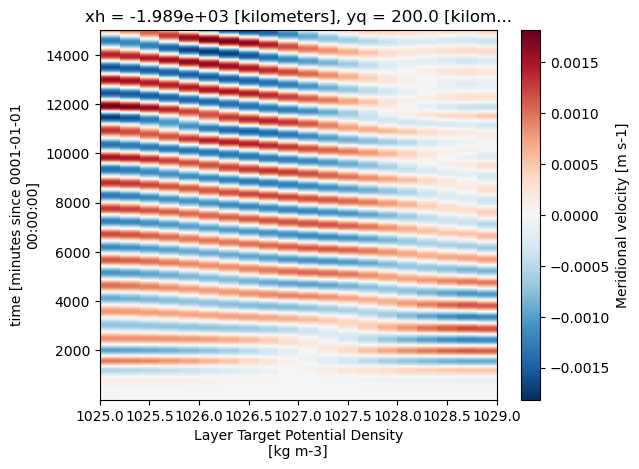

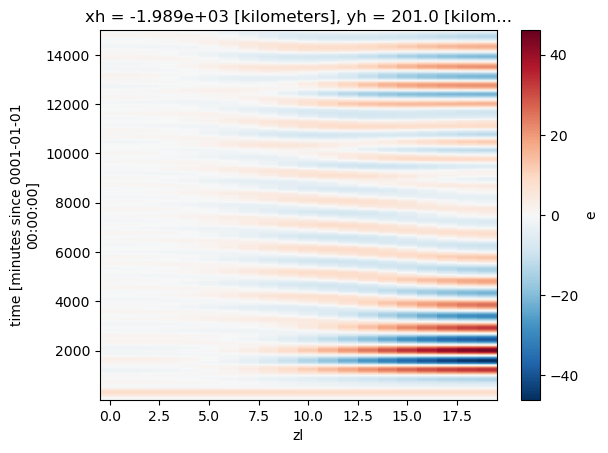

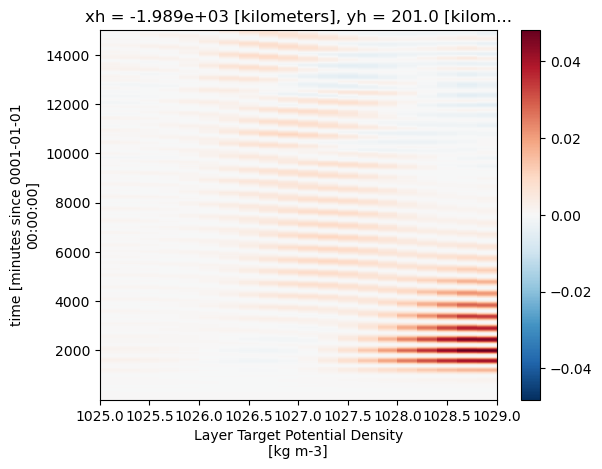

In [57]:
p = calculate_pressure_new(e,u.zl)
v.plot()

plt.figure()
p.plot()

plt.figure()

(p * v).plot()

In [17]:
100 * 2e-5 / 4e-2

0.05

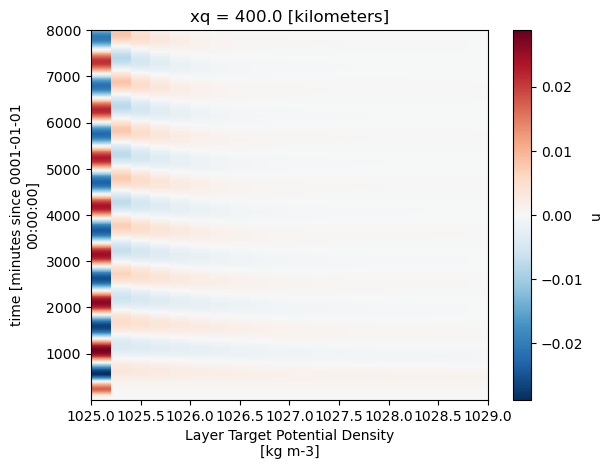

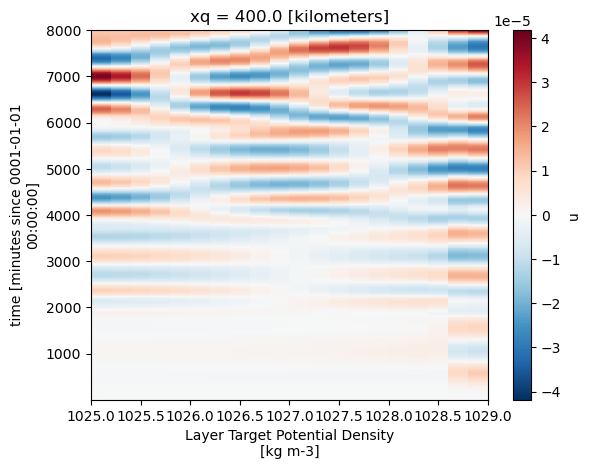

In [4]:
uz.isel(xq = 1200).plot()
plt.figure()
uza = (uz - uz.mean("xq"))
uza.isel(xq = 1200).plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 22.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

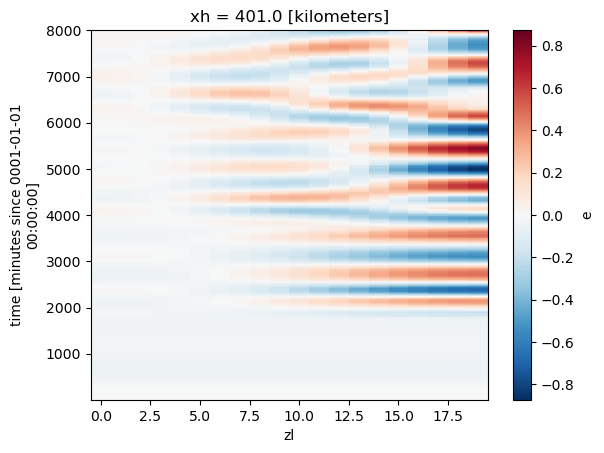

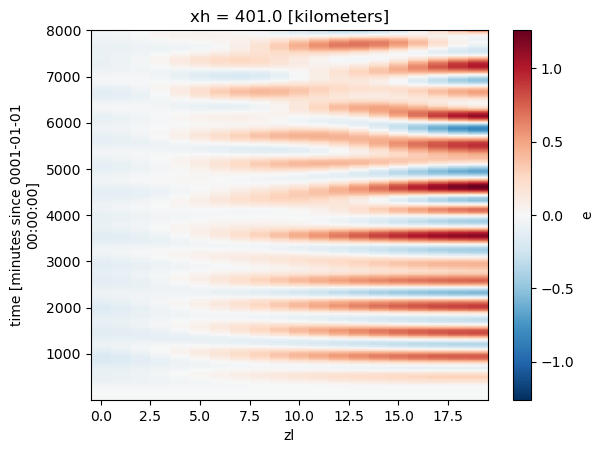

<Figure size 640x480 with 0 Axes>

In [7]:
# pz = calculate_pressure_new(ez,uz.zl)
# pza = (pz - pz.mean("xh"))
pza.isel(xh = 1200).plot()
plt.figure()
pz.isel(xh = 1200).plot()
plt.figure()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 23.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


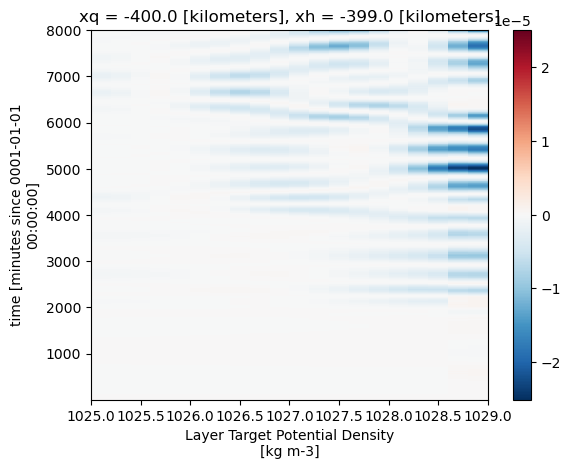

In [18]:
efz = (uza.isel(xq = 800) * pza.isel(xh = 800).assign_coords({"zl":uz.zl})).load()
efz.plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 23.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


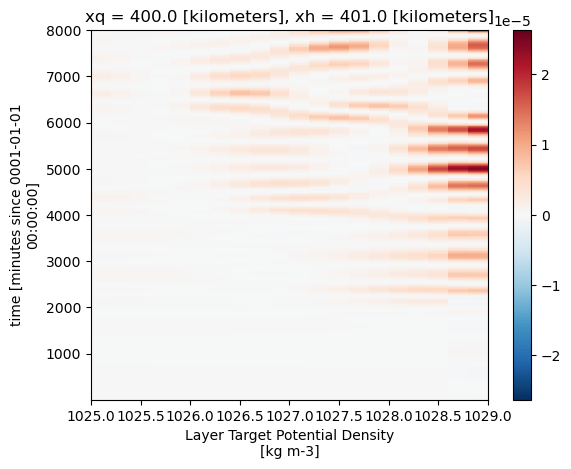

In [16]:
efz = (uza.isel(xq = 1200) * pza.isel(xh = 1200).assign_coords({"zl":uz.zl})).load()
efz.plot()


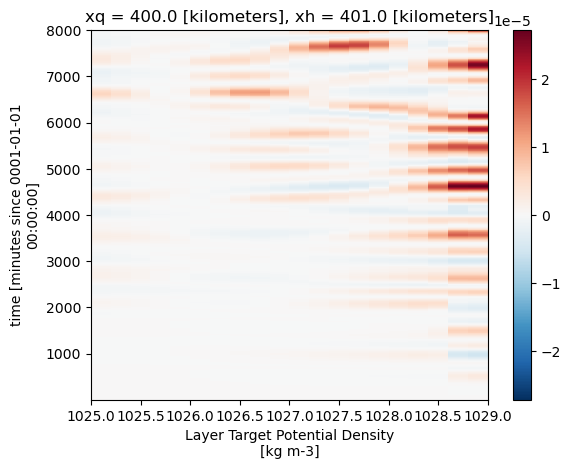

In [15]:
efz.plot()

In [ ]:
pza = (pz - pz.mean("xh")).persist()
uza = (uz - uz.mean("xh")).persist()
uza.plot()
plt.figure()
pza.plot()
plt.figure()
(pza * uza).plot()
plt.figure()
(uz * pz).sel(time = slice(0,8000)).integrate("zl").plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 10.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


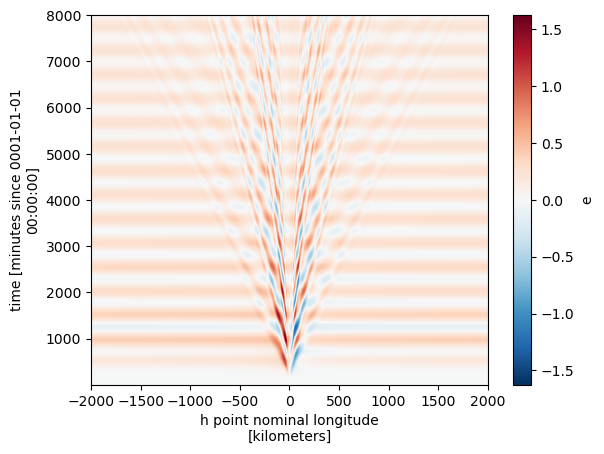

In [19]:
pz.isel(zl = 9).plot()